In [ ]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../') # path to the EVO module
import torch
import torch.nn as nn
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from EVO import DeepNeuralNetwork, EvolutionOptimizer, LogisticRegression

device = torch.device("cuda" if torch.cuda.is_available()
                      else ("mps" if torch.backends.mps.is_available() else "cpu"))

def flatten_tensor(x):
    return x.view(-1)

transform = transforms.Compose([
    transforms.ToTensor(),                        # (1, 28, 28) in [0,1]
    transforms.Normalize((0.1307,), (0.3081,)),   # standard MNIST normalisation
    transforms.Lambda(flatten_tensor)             # flatten to (784,)
    # transforms.Lambda(lambda x: x.view(-1))       # flatten to (784,)
])


train_ds = Subset(
    datasets.MNIST(".", train=True, download=True, transform=transform),
    range(1000)
)
test_ds = Subset(
    datasets.MNIST(".", train=False, download=True, transform=transform),
    range(1000)
)

train_loader = DataLoader(
    train_ds, batch_size=256, shuffle=True,
    num_workers=0, pin_memory=True
)
test_loader = DataLoader(
    test_ds, batch_size=1000,
    num_workers=0, pin_memory=True
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Notebook Cell 2 — model setup & evolution loop

model = DeepNeuralNetwork([784, 32, 10])
model.use_diversity_loss = True
model.diversity_coeff   = 0.2

optimizer = EvolutionOptimizer(model)
optimizer.set_population_size(100)
optimizer.use_backprop = False
optimizer.set_survivors_ratio(0.1)
optimizer.set_fitness_ratio(0.5)
optimizer.set_sneaker_prob(0.01)
optimizer.set_sneakers_ratio(0.05) 
optimizer.set_mutation_intensity(0.05)
optimizer.mutation_rate = 0.1



diversity = []
losses = []
accuracies = []

for gen in range(50):
    for X, y in train_loader:
        optimizer.step(X, y)
    # optionally decay diversity over time
    model.diversity_coeff *= 0.9

    # evaluate on test set
    correct = total = 0
    with torch.no_grad():
        for X, y in test_loader:
            preds = model.predict(X.to(device))
            correct += (preds == y.to(device)).sum().item()
            total   += y.size(0)
    acc = 100 * correct / total

    diversity.append(optimizer.compute_diversity(metric = "euclidean").item())
    losses.append(model.loss(X, y).item())
    accuracies.append(acc)

    print(f"Gen {gen+1:03d} → Test Acc: {acc:.2f}%")


Gen 001 → Test Acc: 7.80%
Gen 002 → Test Acc: 9.00%
Gen 003 → Test Acc: 14.70%
Gen 004 → Test Acc: 7.90%
Gen 005 → Test Acc: 7.90%
Gen 006 → Test Acc: 13.00%
Gen 007 → Test Acc: 14.40%
Gen 008 → Test Acc: 12.30%
Gen 009 → Test Acc: 17.60%
Gen 010 → Test Acc: 17.30%
Gen 011 → Test Acc: 16.50%
Gen 012 → Test Acc: 16.50%
Gen 013 → Test Acc: 18.60%
Gen 014 → Test Acc: 18.60%
Gen 015 → Test Acc: 13.90%
Gen 016 → Test Acc: 16.30%
Gen 017 → Test Acc: 16.30%
Gen 018 → Test Acc: 20.80%
Gen 019 → Test Acc: 15.40%
Gen 020 → Test Acc: 22.00%
Gen 021 → Test Acc: 19.20%
Gen 022 → Test Acc: 18.40%
Gen 023 → Test Acc: 20.70%
Gen 024 → Test Acc: 22.70%
Gen 025 → Test Acc: 23.40%
Gen 026 → Test Acc: 20.70%
Gen 027 → Test Acc: 17.40%
Gen 028 → Test Acc: 17.40%
Gen 029 → Test Acc: 20.00%
Gen 030 → Test Acc: 23.40%
Gen 031 → Test Acc: 20.00%
Gen 032 → Test Acc: 19.80%
Gen 033 → Test Acc: 19.90%
Gen 034 → Test Acc: 23.40%
Gen 035 → Test Acc: 19.90%
Gen 036 → Test Acc: 23.30%
Gen 037 → Test Acc: 19.70%


KeyboardInterrupt: 

In [ ]:
max(accuracies)

82.84

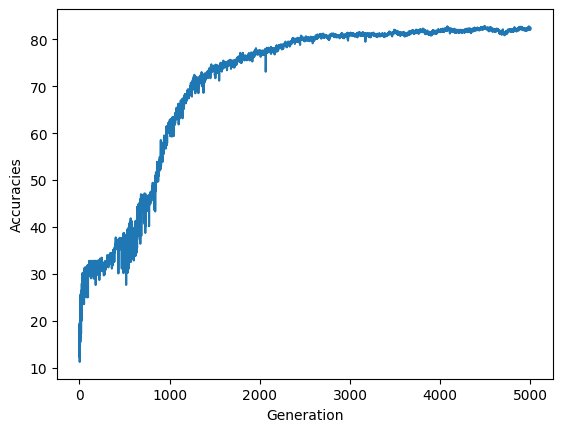

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('Generation')
plt.ylabel('Accuracies')
plt.plot(accuracies)

# Elitism / Survivors Size Comparison

In [40]:
import time
import matplotlib.pyplot as plt
import numpy as np
from EVO import DeepNeuralNetwork, EvolutionOptimizer

thresh_range = np.arange(0.0, 0.25, 0.05)
results_elite = {}

def evaluate_model(model, test_loader):
    correct = total = 0
    with torch.no_grad():
        for X, y in test_loader:
            preds = model.predict(X.to(device))
            correct += (preds == y.to(device)).sum().item()
            total += y.size(0)
    return 100 * correct / total

num_generations = 3 # swag test

Running for survivor ratio = 0%
Gen 01 | Loss: -17.0983 | Test Acc: 11.70% | Diversity: 61.3101
Completed in 4.13s. Final accuracy: 10.50%
Running for survivor ratio = 5%
Gen 01 | Loss: -11.1332 | Test Acc: 9.70% | Diversity: 61.0380
Completed in 3.79s. Final accuracy: 17.50%
Running for survivor ratio = 10%
Gen 01 | Loss: -13.5114 | Test Acc: 11.20% | Diversity: 60.8878
Completed in 4.58s. Final accuracy: 9.40%
Running for survivor ratio = 15%
Gen 01 | Loss: -14.7695 | Test Acc: 8.80% | Diversity: 59.8518
Completed in 4.38s. Final accuracy: 11.40%
Running for survivor ratio = 20%
Gen 01 | Loss: -11.1730 | Test Acc: 7.50% | Diversity: 60.0752
Completed in 3.82s. Final accuracy: 10.10%


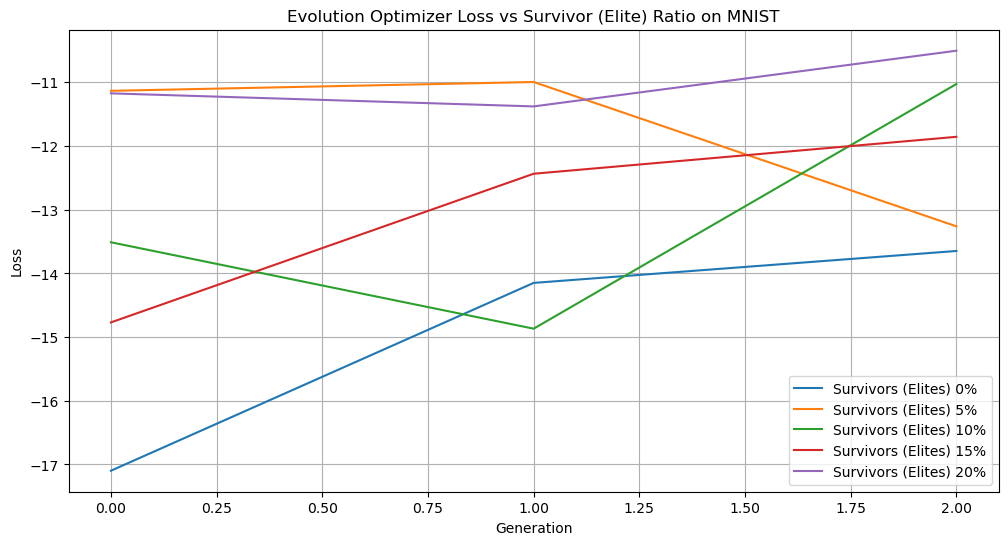

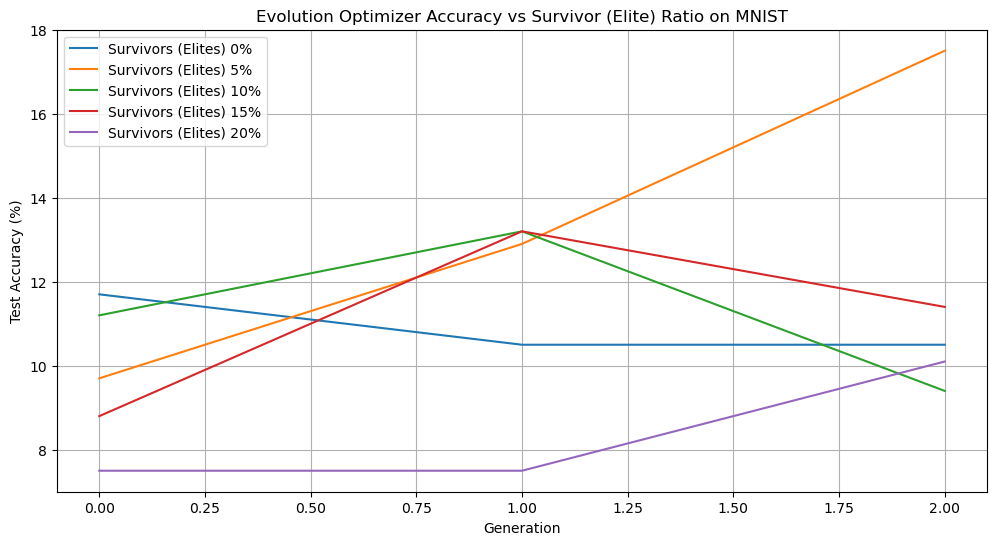

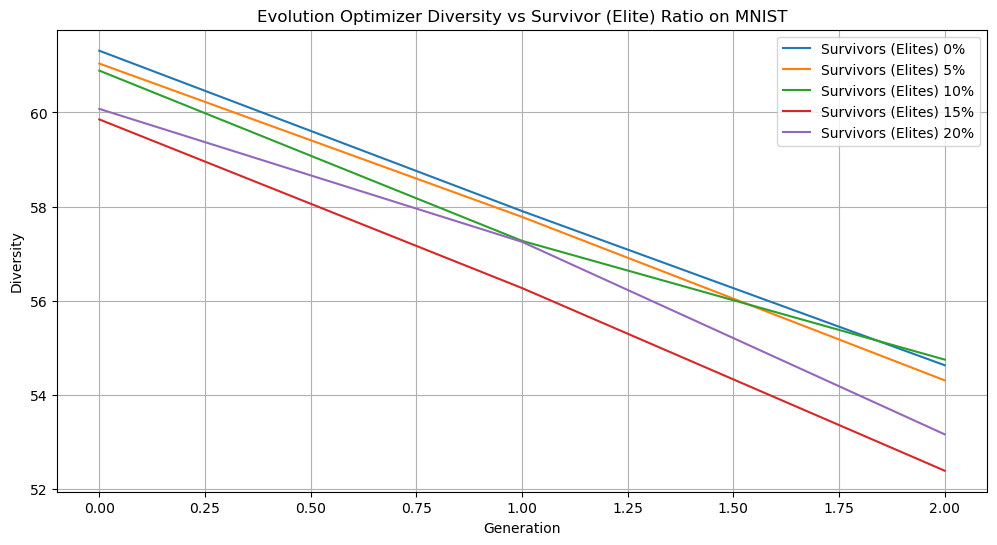

In [41]:
for thresh in range(len(thresh_range)):
    survivor_ratio = thresh_range[thresh]
    print(f"Running for survivor ratio = {survivor_ratio*100:.0f}%")
    
    model = DeepNeuralNetwork([784, 32, 10])
    model.use_diversity_loss = True
    model.diversity_coeff = 0.1
    
    optimizer = EvolutionOptimizer(model)
    optimizer.set_population_size(50)
    optimizer.use_backprop = False  
    optimizer.set_survivors_ratio(survivor_ratio)
    optimizer.set_fitness_ratio(0.5)
    optimizer.set_sneaker_prob(0.01)
    optimizer.set_sneakers_ratio(0.05) 
    optimizer.set_mutation_intensity(0.05)
    optimizer.mutation_rate = 0.1
    
    losses = []
    accuracies = []
    diversity = []
    start = time.time()
    
    for gen in range(num_generations):
        for X, y in train_loader:
            optimizer.step(X, y)
        
        losses.append(model.loss(X, y).item())

        div = optimizer.compute_diversity(metric="euclidean").item()
        diversity.append(div)
        
        acc = evaluate_model(model, test_loader)
        accuracies.append(acc)
        
        if gen % 10 == 0:
            print(f"Gen {gen+1:02d} | Loss: {losses[-1]:.4f} | Test Acc: {acc:.2f}% | Diversity: {div:.4f}")
    
    duration = round(time.time() - start, 2)
    print(f"Completed in {duration}s. Final accuracy: {accuracies[-1]:.2f}%")
    
    results_elite[survivor_ratio] = {
        'losses': losses,
        'accuracies': accuracies,
        'diversity': diversity,
    }

# Plot loss
plt.figure(figsize=(12, 6))
for ratio, data in results_elite.items():
    plt.plot(data['losses'], label=f"Survivors (Elites) {ratio*100:.0f}%")

plt.xlabel("Generation")
plt.ylabel("Loss")
plt.title("Evolution Optimizer Loss vs Survivor (Elite) Ratio on MNIST")
plt.legend()
plt.grid(True)
plt.show()

# Plot acc
plt.figure(figsize=(12, 6))
for ratio, data in results_elite.items():
    plt.plot(data['accuracies'], label=f"Survivors (Elites) {ratio*100:.0f}%")

plt.xlabel("Generation")
plt.ylabel("Test Accuracy (%)")
plt.title("Evolution Optimizer Accuracy vs Survivor (Elite) Ratio on MNIST")
plt.legend()
plt.grid(True)
plt.show()

# Plot diversity
plt.figure(figsize=(12, 6))
for ratio, data in results_elite.items():
    plt.plot(data['diversity'], label=f"Survivors (Elites) {ratio*100:.0f}%")
plt.xlabel("Generation")
plt.ylabel("Diversity")
plt.title("Evolution Optimizer Diversity vs Survivor (Elite) Ratio on MNIST")
plt.legend()
plt.grid(True)
plt.show()

# Fitness / Gene Pool Size Comparison

Running for gene pool size = 10%
Gen 01 | Loss: -8.6071 | Test Acc: 12.10% | Diversity: 40.8984
Completed in 4.09s. Final accuracy: 14.80%
Running for gene pool size = 20%
Gen 01 | Loss: -6.6836 | Test Acc: 12.60% | Diversity: 51.6636
Completed in 4.08s. Final accuracy: 13.50%
Running for gene pool size = 30%
Gen 01 | Loss: -14.1138 | Test Acc: 12.00% | Diversity: 57.6545
Completed in 4.28s. Final accuracy: 13.30%
Running for gene pool size = 40%
Gen 01 | Loss: -12.1104 | Test Acc: 7.40% | Diversity: 58.6358
Completed in 4.08s. Final accuracy: 8.30%
Running for gene pool size = 50%
Gen 01 | Loss: -14.8115 | Test Acc: 8.30% | Diversity: 61.2020
Completed in 4.49s. Final accuracy: 7.80%
Running for gene pool size = 60%
Gen 01 | Loss: -15.5456 | Test Acc: 11.40% | Diversity: 61.1319
Completed in 4.51s. Final accuracy: 11.40%
Running for gene pool size = 70%
Gen 01 | Loss: -12.4870 | Test Acc: 12.10% | Diversity: 61.9441
Completed in 4.38s. Final accuracy: 13.10%
Running for gene pool size

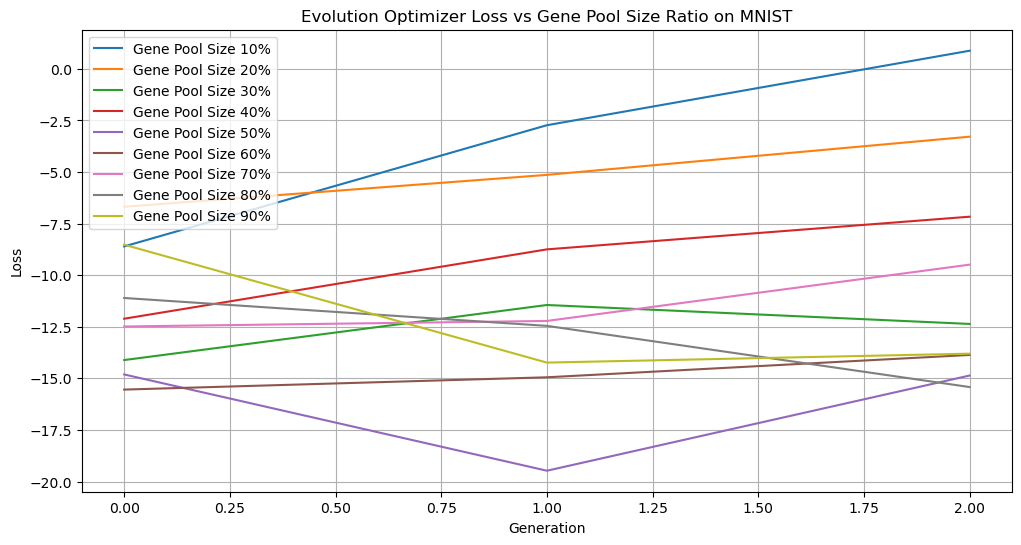

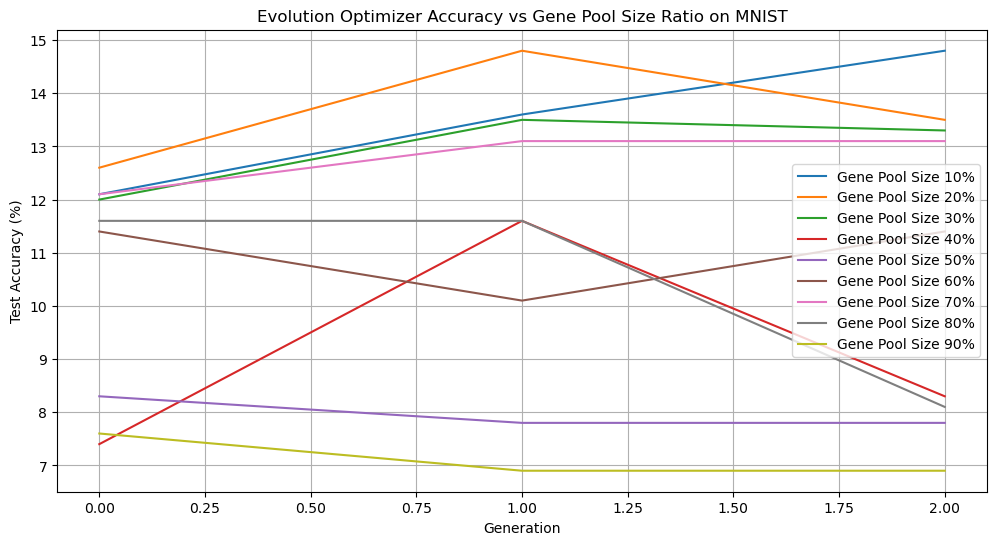

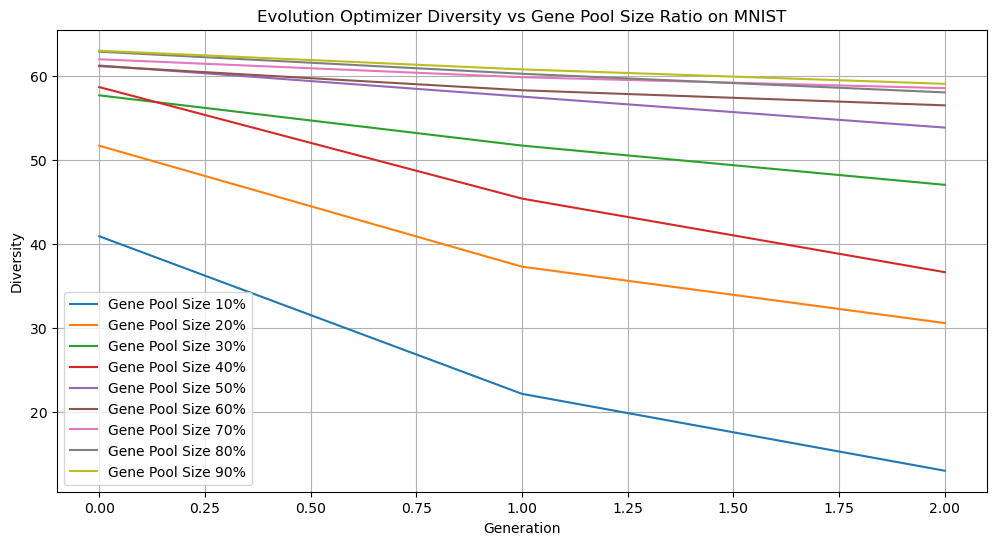

In [42]:
thresh_range = np.arange(0.1, 1.0, 0.1)
results_pool = {}

for thresh in range(len(thresh_range)):
    pool_size = thresh_range[thresh]
    print(f"Running for gene pool size = {pool_size*100:.0f}%")
    
    model = DeepNeuralNetwork([784, 32, 10])
    model.use_diversity_loss = True
    model.diversity_coeff = 0.1
    
    optimizer = EvolutionOptimizer(model)
    optimizer.set_population_size(50)
    optimizer.use_backprop = False  
    optimizer.set_survivors_ratio(0.1)
    optimizer.set_fitness_ratio(pool_size)
    optimizer.set_sneaker_prob(0.01)
    optimizer.set_sneakers_ratio(0.05)
    optimizer.set_mutation_intensity(0.05)
    optimizer.mutation_rate = 0.1
    
    losses = []
    accuracies = []
    diversity = []
    start = time.time()
    
    for gen in range(num_generations):
        for X, y in train_loader:
            optimizer.step(X, y)
        
        losses.append(model.loss(X, y).item())

        div = optimizer.compute_diversity(metric="euclidean").item()
        diversity.append(div)
        
        acc = evaluate_model(model, test_loader)
        accuracies.append(acc)
        
        if gen % 10 == 0:
            print(f"Gen {gen+1:02d} | Loss: {losses[-1]:.4f} | Test Acc: {acc:.2f}% | Diversity: {div:.4f}")
    
    duration = round(time.time() - start, 2)
    print(f"Completed in {duration}s. Final accuracy: {accuracies[-1]:.2f}%")
    
    results_pool[pool_size] = {
        'losses': losses,
        'accuracies': accuracies,
        'diversity': diversity,
    }

# Plot loss
plt.figure(figsize=(12, 6))
for ratio, data in results_pool.items():
    plt.plot(data['losses'], label=f"Gene Pool Size {ratio*100:.0f}%")

plt.xlabel("Generation")
plt.ylabel("Loss")
plt.title("Evolution Optimizer Loss vs Gene Pool Size Ratio on MNIST")
plt.legend()
plt.grid(True)
plt.show()

# Plot acc
plt.figure(figsize=(12, 6))
for ratio, data in results_pool.items():
    plt.plot(data['accuracies'], label=f"Gene Pool Size {ratio*100:.0f}%")

plt.xlabel("Generation")
plt.ylabel("Test Accuracy (%)")
plt.title("Evolution Optimizer Accuracy vs Gene Pool Size Ratio on MNIST")
plt.legend()
plt.grid(True)
plt.show()

# Plot diversity
plt.figure(figsize=(12, 6))
for ratio, data in results_pool.items():
    plt.plot(data['diversity'], label=f"Gene Pool Size {ratio*100:.0f}%")
plt.xlabel("Generation")
plt.ylabel("Diversity")
plt.title("Evolution Optimizer Diversity vs Gene Pool Size Ratio on MNIST")
plt.legend()
plt.grid(True)
plt.show()

Running for sneaker probability = 0%
Gen 01 | Loss: -13.3198 | Test Acc: 9.30% | Diversity: 59.8768
Completed in 4.08s. Final accuracy: 18.00%
Running for sneaker probability = 5%
Gen 01 | Loss: -14.1456 | Test Acc: 12.50% | Diversity: 61.2877
Completed in 3.82s. Final accuracy: 12.40%
Running for sneaker probability = 10%
Gen 01 | Loss: -13.6539 | Test Acc: 9.80% | Diversity: 60.2957
Completed in 4.26s. Final accuracy: 11.70%
Running for sneaker probability = 15%
Gen 01 | Loss: -21.1569 | Test Acc: 12.60% | Diversity: 62.6935
Completed in 3.98s. Final accuracy: 12.60%
Running for sneaker probability = 20%
Gen 01 | Loss: -20.5393 | Test Acc: 11.50% | Diversity: 62.0643
Completed in 3.34s. Final accuracy: 11.50%
Running for sneaker probability = 25%
Gen 01 | Loss: -15.1747 | Test Acc: 14.20% | Diversity: 60.8491
Completed in 3.45s. Final accuracy: 14.20%
Running for sneaker probability = 30%
Gen 01 | Loss: -10.5970 | Test Acc: 7.90% | Diversity: 61.5062
Completed in 3.71s. Final accurac

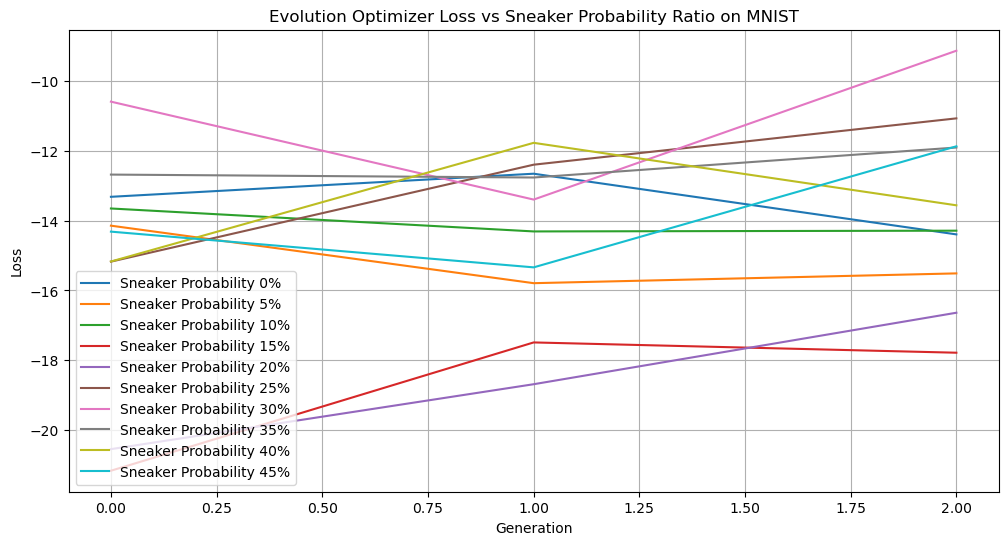

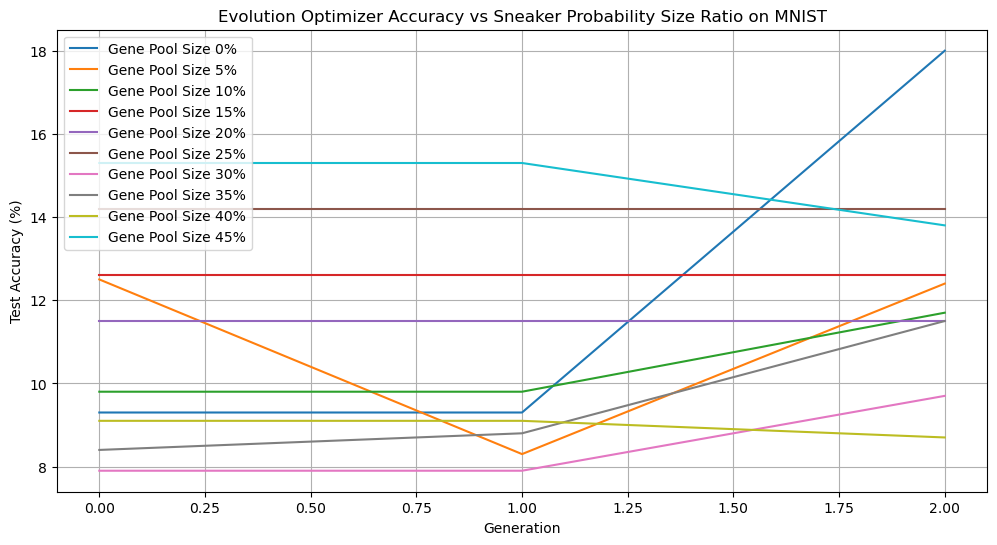

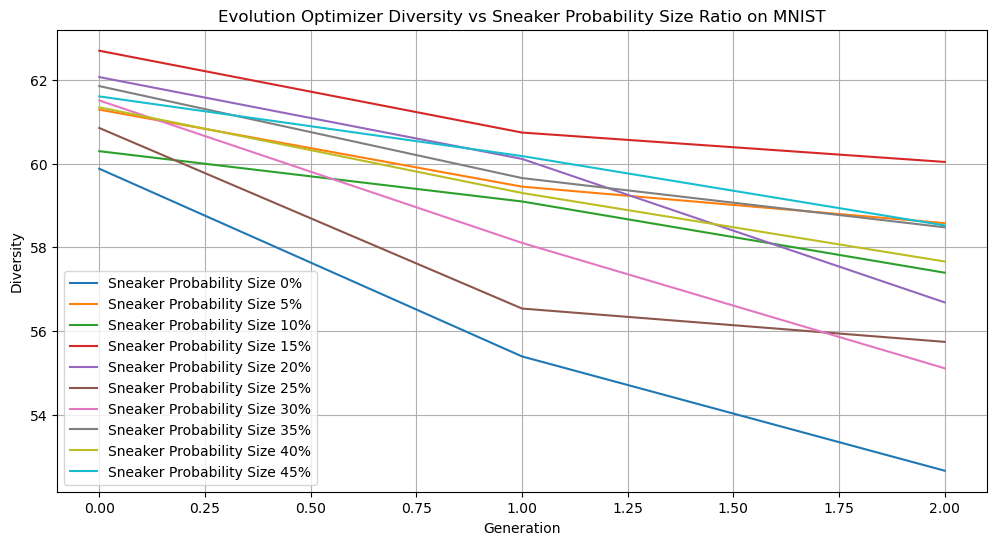

In [43]:
thresh_range = np.arange(0.0, 0.5, 0.05)
results_snk = {}

for thresh in range(len(thresh_range)):
    snk_ratio = thresh_range[thresh]
    print(f"Running for sneaker probability = {snk_ratio*100:.0f}%")
    
    model = DeepNeuralNetwork([784, 32, 10])
    model.use_diversity_loss = True
    model.diversity_coeff = 0.1
    
    optimizer = EvolutionOptimizer(model)
    optimizer.set_population_size(50)
    optimizer.use_backprop = False  
    optimizer.set_survivors_ratio(0.5)
    optimizer.set_fitness_ratio(0.5)
    optimizer.set_sneaker_prob(snk_ratio)
    optimizer.set_sneakers_ratio(0.05)
    optimizer.set_mutation_intensity(0.05)
    optimizer.mutation_rate = 0.1
    
    losses = []
    accuracies = []
    diversity = []
    start = time.time()
    
    for gen in range(num_generations):
        for X, y in train_loader:
            optimizer.step(X, y)
        
        losses.append(model.loss(X, y).item())

        div = optimizer.compute_diversity(metric="euclidean").item()
        diversity.append(div)
        
        acc = evaluate_model(model, test_loader)
        accuracies.append(acc)
        
        if gen % 10 == 0:
            print(f"Gen {gen+1:02d} | Loss: {losses[-1]:.4f} | Test Acc: {acc:.2f}% | Diversity: {div:.4f}")
    
    duration = round(time.time() - start, 2)
    print(f"Completed in {duration}s. Final accuracy: {accuracies[-1]:.2f}%")
    
    results_snk[snk_ratio] = {
        'losses': losses,
        'accuracies': accuracies,
        'diversity': diversity,
    }

# Plot loss
plt.figure(figsize=(12, 6))
for ratio, data in results_snk.items():
    plt.plot(data['losses'], label=f"Sneaker Probability {ratio*100:.0f}%")

plt.xlabel("Generation")
plt.ylabel("Loss")
plt.title("Evolution Optimizer Loss vs Sneaker Probability Ratio on MNIST")
plt.legend()
plt.grid(True)
plt.show()

# Plot acc
plt.figure(figsize=(12, 6))
for ratio, data in results_snk.items():
    plt.plot(data['accuracies'], label=f"Gene Pool Size {ratio*100:.0f}%")

plt.xlabel("Generation")
plt.ylabel("Test Accuracy (%)")
plt.title("Evolution Optimizer Accuracy vs Sneaker Probability Size Ratio on MNIST")
plt.legend()
plt.grid(True)
plt.show()

# Plot diversity
plt.figure(figsize=(12, 6))
for ratio, data in results_snk.items():
    plt.plot(data['diversity'], label=f"Sneaker Probability Size {ratio*100:.0f}%")
plt.xlabel("Generation")
plt.ylabel("Diversity")
plt.title("Evolution Optimizer Diversity vs Sneaker Probability Size Ratio on MNIST")
plt.legend()
plt.grid(True)
plt.show()